## Generate Dataset

In [1]:
from sklearn.datasets import make_moons

moons_X, moons_y = make_moons(n_samples=10_000, noise=0.4)

In [2]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(moons_X, moons_y, test_size = 0.2, random_state = 42)

print(train_X.shape, train_y.shape)

(8000, 2) (8000,)


## Learning Curve

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

def plot_learning_curve(model, X, y, n_steps = 20):
    train_errors = []
    val_errors = []
    
    train_X, val_X, train_y, val_y = train_test_split(moons_X, moons_y, test_size = 0.2, random_state = 42)
    
    step_size = int(train_X.shape[0] / n_steps)
    start = train_X.shape[0] - step_size * (n_steps - 1)

    for m in range(step_size, train_X.shape[0], step_size):
        model.fit(train_X[:m], train_y[:m])
        train_predict = model.predict(train_X[:m])
        val_predict = model.predict(val_X)
        
        train_errors.append(mean_squared_error(train_y[:m], train_predict))
        val_errors.append(mean_squared_error(val_y, val_predict))
    
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()
    

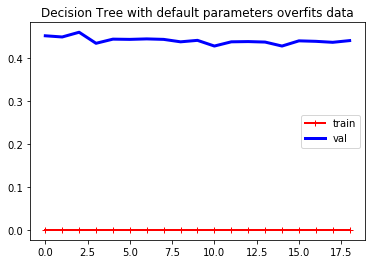

In [4]:
from sklearn.tree import DecisionTreeClassifier

plot_learning_curve(DecisionTreeClassifier(), moons_X, moons_y)

plt.title("Decision Tree with default parameters overfits data")
plt.show()

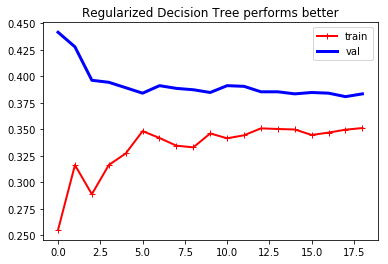

In [5]:
plot_learning_curve(DecisionTreeClassifier(max_depth = 7), moons_X, moons_y)

plt.title("Regularized Decision Tree performs better")
plt.show()

## Grid Search with Cross-Validation

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

parameters = {
    'max_leaf_nodes': [2, 3, 4, 5, 7, 10, 15, 20, None],
    'max_depth': [2, 3, 4, 5, 7, 10, 15, 20, None]
}

search = GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5, scoring='accuracy', n_jobs=-1)

In [7]:
%%time

search.fit(train_X, train_y)
print('best params', search.best_params_)

best params {'max_depth': 5, 'max_leaf_nodes': 15}
Wall time: 2.59 s


In [8]:
model = search.best_estimator_
model.score(test_X, test_y)

0.856

## Random Forest

In [9]:
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits = 1000, test_size = None, train_size = 100, random_state = 42)

In [10]:
%%time

forest = []

for indices, _ in rs.split(train_X):
    model = DecisionTreeClassifier(**search.best_params_)
    model.fit(train_X[indices], train_y[indices])
    forest.append(model)


Wall time: 580 ms


In [14]:
scores = [model.score(test_X, test_y) for model in forest]

print('best score: ', np.max(scores))

best score:  0.8555


In [15]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score

predicts = np.array([model.predict(test_X) for model in forest])
forest_predicts = mode(predicts, axis=0)
forest_predicts = forest_predicts[0].reshape(-1)
accuracy_score(forest_predicts, test_y)

0.8625